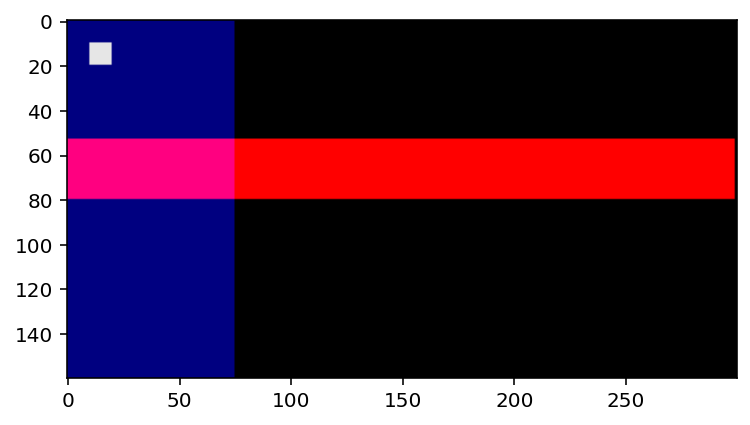

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import numpy as np
from skimage import io
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
maxX = 300
maxY = 160
A = np.zeros([maxY,maxX,3],dtype='uint8')
A[maxY//3:maxY//2 , 0:maxX-1, 0] = 255
A[0:maxY , 0:maxX//4,2] = 128
A[ 10:20, 10:20,:] = 230
plt.imshow(A)
plt.show()
#io.imsave('almost_a_flag.jpg',A)

In [2]:
def PrintArrayInfo(a):
    print("Array info:")
    print("shape:", a.shape)
    print("dtype:", a.dtype)
    print("min, max:", a.min(), a.max())

## Read Image

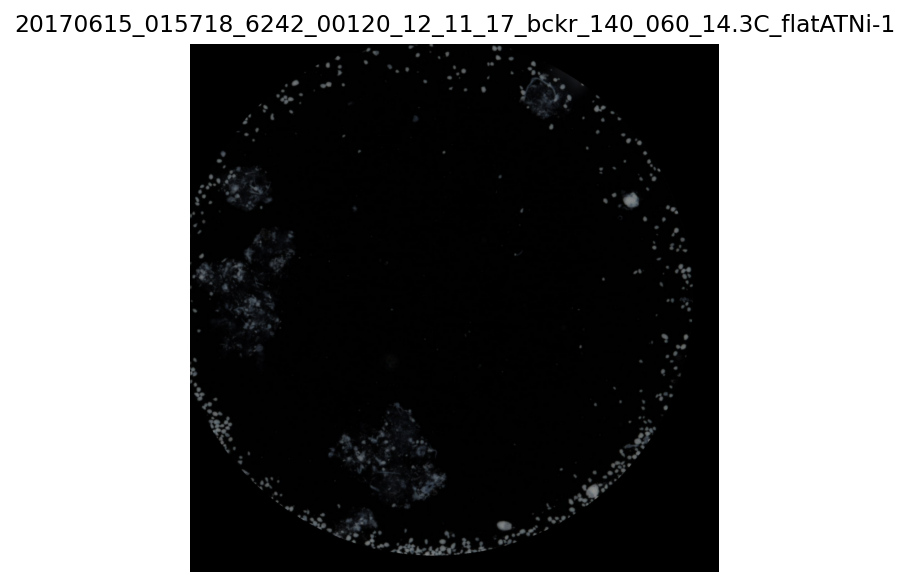

In [3]:
from matplotlib.pyplot import figure
image = io.imread('20170616_194217_6242_00120_12_11_17_bckr_140_070_13.1C_flatATNi.jpg')
fig, ax = plt.subplots(figsize=(5,5),dpi=70)
ax.imshow(image, cmap='gray')
plt.axis('off') # turn off axis labels
ax.set_title('20170615_015718_6242_00120_12_11_17_bckr_140_060_14.3C_flatATNi-1')
plt.show()

## Convert image to grayscale

In [28]:
from skimage import data
from skimage.color import rgb2gray
from matplotlib.pyplot import figure

#figure(figsize=(8, 6), dpi=150)

original = image
grayscale = rgb2gray(original)

fig, axes = plt.subplots(1, 2, figsize=(9, 9),dpi=100)
ax = axes.ravel()

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")
fig.tight_layout()
plt.axis('off')
plt.show()

## Thresholding

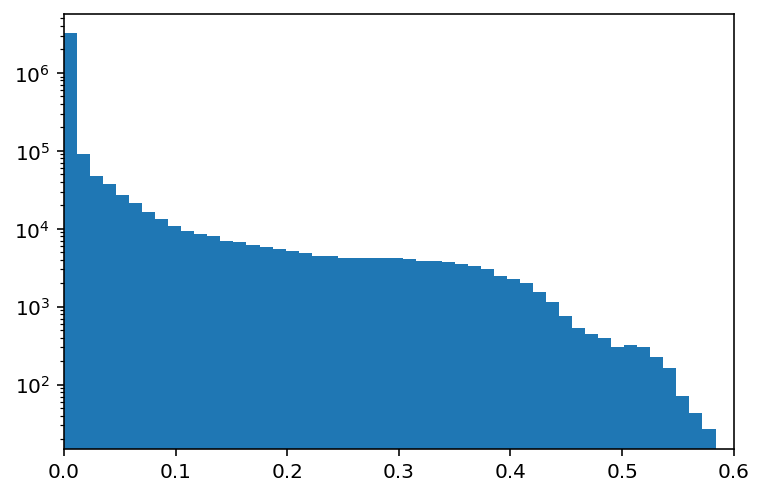

In [5]:
plt.hist(grayscale.ravel(),50)
plt.xlim(0,0.6)
plt.yscale('log')
plt.show()

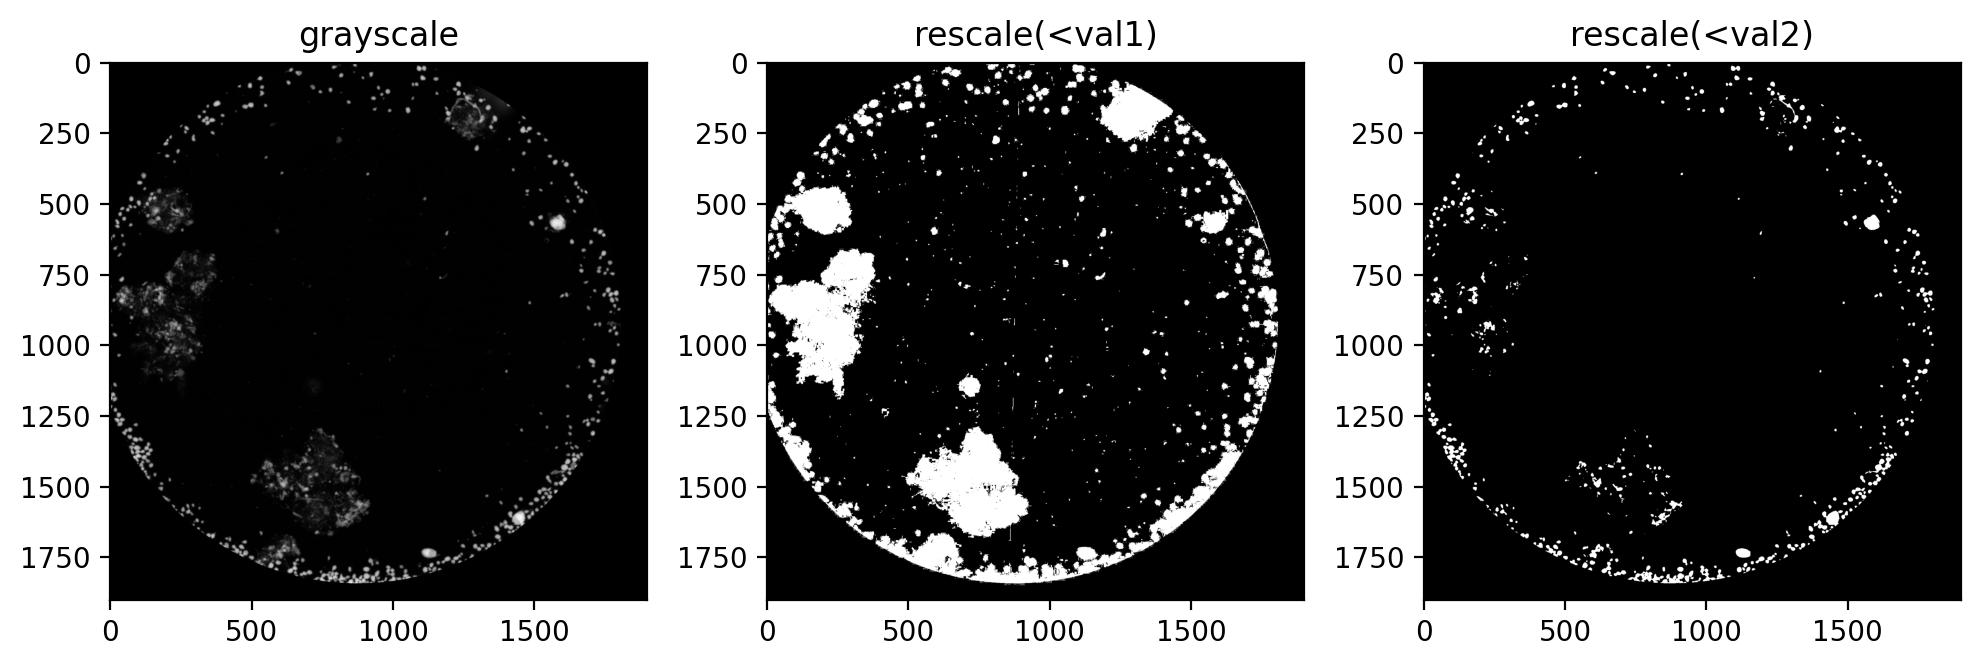

In [6]:
val1 = 0.007
val2 = 0.2
normal_rescale_1 = (grayscale > val1)
normal_rescale_2 = (grayscale > val2)
fig, axes = plt.subplots(1, 3, figsize=(10, 10),dpi=100)
ax = axes.ravel()
ax[0].imshow(grayscale, cmap=plt.cm.gray)
ax[0].set_title("grayscale")
ax[1].imshow(normal_rescale_1, cmap=plt.cm.gray)
ax[1].set_title("rescale(<val1)")
ax[2].imshow(normal_rescale_2, cmap=plt.cm.gray)
ax[2].set_title("rescale(<val2)")

fig.tight_layout()
#plt.axis('off')
plt.show()

In [7]:
from skimage.morphology import disk, erosion, dilation, opening, closing, diameter_opening
from matplotlib.pyplot import figure
from skimage import measure
from skimage.color import label2rgb
from matplotlib.pyplot import figure
selector = disk(1)

In [8]:
regions1 = opening(normal_rescale_1, selector)
#regions1 = diameter_opening(normal_rescale_1, diameter_threshold=200, connectivity=10)
regions2 = opening(normal_rescale_2, selector)

In [9]:
labels1 = measure.label(regions1)
labels2 = measure.label(regions2)

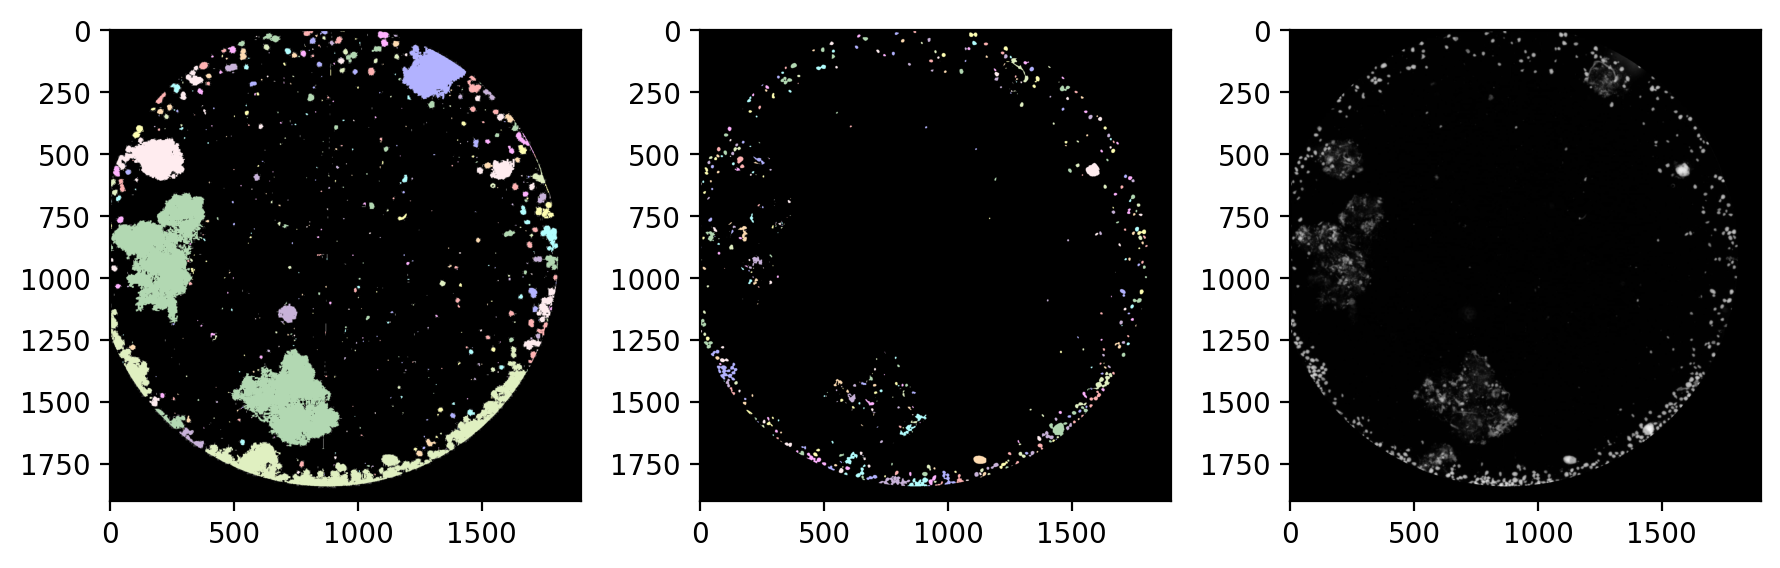

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(9, 9),dpi=100)
ax = axes.ravel()
image_label_overlay1 = label2rgb(labels1, image=normal_rescale_1)
image_label_overlay2 = label2rgb(labels2, image=normal_rescale_2)
ax[0].imshow(image_label_overlay1,cmap='gray')
ax[1].imshow(image_label_overlay2,cmap='gray')
ax[2].imshow(grayscale,cmap='gray')
fig.tight_layout()
plt.show()

In [11]:
##test
##first decide whether it is an aggregate
## if Yes:Count as one particle, calculate area
## if No:Find the original greyscale and rescale, apply watershed overlapping decision

In [12]:
props = measure.regionprops(labels1)
print(len(np.unique(labels1)))

624


## Particle searcher

In [13]:
max_index=0
max_area=0

for i in range(len(props)):
    if props[i].area>max_area and props[i].area<5805:
        max_area=props[i].area
        max_index=i
print(max_index,max_area)

398 4539


In [14]:
def analyze(index,regions):
    label = measure.label(regions)
    props=measure.regionprops(label)
    bubble = props[index]
    # get the coordinates of the bubble
    x1, y1, x2, y2 = bubble.bbox
    # Make a new image with the dimensions of the original one
    fig, axes = plt.subplots(1, 4, figsize=(10, 10),dpi=100)
    ax = axes.ravel()
    img = np.zeros(regions.shape,dtype=bool)
    # place the bubble image in the correct location in the new image
    img[x1:x2,y1:y2] = bubble.image
    ax[0].imshow(normal_rescale_1,cmap='gray')
    ax[1].imshow(img,cmap='gray')
    ax[2].imshow(img[x1:x2,y1:y2])
    ax[3].imshow(grayscale[x1:x2,y1:y2],cmap='gray')
    plt.show()
    
    #Calculate the average intensity
    total=0
    number=0
    new_image=img[x1:x2,y1:y2]
    new_grayscale=grayscale[x1:x2,y1:y2]
    for i in range(x2-x1):
        for j in range(y2-y1):
            if new_image[i,j]==True:
                total+=new_grayscale[i,j]
                number+=1
    avg_intensity=total/number
    print('average_intensity of particle group:',avg_intensity)
    
    if avg_intensity>0.1: #particles
        part_image=grayscale[x1:x2,y1:y2]
        TF_image=img[x1:x2,y1:y2]
        print(part_image.shape)
        plt.imshow(part_image,cmap='gray')
        for i in range(TF_image.shape[0]):
            for j in range(TF_image.shape[1]):
                if TF_image[i,j]==False:
                    part_image[i,j]=0
        #plt.imshow(part_image>0.2,cmap='gray')
        print('not aggregate, do watershed')
        watershed(part_image>0.2)
        
    else:
        area=total
        if area>50:
            print('this should be an aggregate')
        else:
            print('neglect, noise')
    

## Watershed Function

In [15]:
from scipy import ndimage as ndi
from scipy import ndimage as ndi
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)
def watershed(input_image):
    distance = ndi.distance_transform_edt(input_image)
    local_max_coords = feature.peak_local_max(distance, min_distance=5)
    local_max_mask = np.zeros(distance.shape, dtype=bool)
    local_max_mask[tuple(local_max_coords.T)] = True
    markers = measure.label(local_max_mask)
    aggragates = segmentation.watershed(-distance, markers, mask=input_image)
    return aggragates

In [16]:
def analyze(regions):
    n_particle=0
    n_aggragate=0
    A_particle=[]
    A_aggragate=[]
    particle_ndx=[]
    aggregate_ndx=[]
    
    threshold=50 #count particles > 50 pixels
    aggregate_cutoff=0.1 #cutoff between particle and aggregate
    
    
    label = measure.label(regions)
    props=measure.regionprops(label)
    for index in range(len(props)):
        bubble = props[index]
        # get the coordinates of the bubble
        x1, y1, x2, y2 = bubble.bbox
        img = np.zeros(regions.shape,dtype=bool)
        img[x1:x2,y1:y2] = bubble.image

        #Calculate the average intensity
        total=0
        number=0
        new_image=img[x1:x2,y1:y2]
        new_grayscale=grayscale[x1:x2,y1:y2]
        for i in range(x2-x1):
            for j in range(y2-y1):
                if new_image[i,j]==True:
                    total+=new_grayscale[i,j]
                    number+=1
        avg_intensity=total/number
        #print('average_intensity of particle group:',avg_intensity)
        if avg_intensity<0.1:
            area=props[index].area
            if area>1000:
                aggregate_ndx.append(index)
                n_aggragate+=1
                A_aggragate.append(area)
        else: #particles
            particle_ndx.append(index)
            part_image=grayscale[x1:x2,y1:y2]
            TF_image=img[x1:x2,y1:y2]

            for i in range(TF_image.shape[0]):
                for j in range(TF_image.shape[1]):
                    if TF_image[i,j]==False:
                        part_image[i,j]=0

            local_marker = watershed(part_image>0.2)
            local_props = measure.regionprops(local_marker)
            
            for local_index in range(len(local_props)):
                this_area=local_props[local_index].area
                if this_area>threshold:
                    n_particle+=1
                    A_particle.append(this_area)
                    #print(local_index)
        
                #print('this should be an aggregate')
            #else:
                #print('neglect, noise')
    return [n_particle,A_particle,particle_ndx,n_aggragate,A_aggragate,aggregate_ndx]

In [17]:
result=analyze(regions1)

In [18]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.hist(esd,3000,cumulative=-1,density=True, histtype='step')
# plt.xscale('log')
# plt.xlim(10**2,10**4)
# plt.xlabel('ESD(um)')
# plt.ylabel('Normal Cumulative ATN')
# plt.show()

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt 

In [20]:
regions=regions1

In [27]:
# movie parameters
from matplotlib.animation import FFMpegWriter
metadata = dict(title='single_particle',artist='Yunhao',comment='...')
writer = FFMpegWriter(fps=15, metadata=metadata)
fig = plt.figure()

with writer.saving(fig, "single_particle.mp4", dpi=200):
    
    threshold=50 #count particles > 50 pixels
    aggregate_cutoff=0.1 #cutoff between particle and aggregate
    n_particle=0
    n_aggragate=0
    A_particle=[]
    A_aggragate=[]
    particle_ndx=[]
    aggregate_ndx=[]
    iterations = 328
    label = measure.label(regions)
    props=measure.regionprops(label)
    iteration=range(len(props))
    is_particle=True
    
    for index in range(len(props)):
        bubble = props[index]
        # get the coordinates of the bubble
        x1, y1, x2, y2 = bubble.bbox
        img = np.zeros(regions.shape,dtype=bool)
        img[x1:x2,y1:y2] = bubble.image

        #Calculate the average intensity
        total=0
        number=0
        new_image=img[x1:x2,y1:y2]
        new_grayscale=grayscale[x1:x2,y1:y2]
        for i in range(x2-x1):
            for j in range(y2-y1):
                if new_image[i,j]==True:
                    total+=new_grayscale[i,j]
                    number+=1
        avg_intensity=total/number
        #print('average_intensity of particle group:',avg_intensity)
        
        
        if avg_intensity<0.1:
            is_particlear=False
            area=props[index].area
            if area>1000:
                aggregate_ndx.append(index)
                n_aggragate+=1
                A_aggragate.append(area)
        else: #particles
            is_particle=True
            particle_ndx.append(index)
            part_image=grayscale[x1:x2,y1:y2]
            TF_image=img[x1:x2,y1:y2]

            for i in range(TF_image.shape[0]):
                for j in range(TF_image.shape[1]):
                    if TF_image[i,j]==False:
                        part_image[i,j]=0

            new_image = part_image>0.2
            distance = ndi.distance_transform_edt(new_image)
            local_max_coords = feature.peak_local_max(distance, min_distance=5)
            local_max_mask = np.zeros(distance.shape, dtype=bool)
            local_max_mask[tuple(local_max_coords.T)] = True
            markers = measure.label(local_max_mask)
            local_marker = segmentation.watershed(-distance, markers, mask=new_image)
            
            local_props = measure.regionprops(local_marker)
            
            for local_index in range(len(local_props)):
                this_area=local_props[local_index].area
                if this_area>threshold:
                    n_particle+=1
                    A_particle.append(this_area)
        

            all_areas=np.concatenate((np.asarray(A_particle),np.asarray(A_aggragate)),axis=0)
            esd=2*np.sqrt((all_areas*13**2)/np.pi)
        
        #fig, ax = plt.subplots(1,3)
        if index%2==0:
#             fig.clf()
#             ax[0].hist(esd,3000,cumulative=-1,density=True, histtype='step')
#             ax[0].set_xscale('log')
#             ax[0].set_xlim(10**2,10**4)
#             ax[0].set_xlabel('ESD(um)')
#             ax[0].set_ylabel('Normal Cumulative ATN')
#             ax[1].imshow(img)
#             ax[1].set_title('Whole Picture')
#             if is_particle:
#                 ax[2].imshow(color.label2rgb(local_marker, bg_label=0))
#             else:
#                 ax[2].imshow(img,cmap='gray')
#             ax[2].set_title('Single Picture')
#             fig.tight_layout()
#             renderer = fig.canvas.renderer
#             fig.draw(renderer)
#             plt.pause(0.1)
#             writer.grab_frame()
            
            
#====================working,hist==============================            
#             plt.clf()
#             plt.xscale('log')
#             plt.xlim(10**2,10**4)
#             plt.hist(esd,3000,cumulative=-1,density=True, histtype='step')
#             plt.xlabel('ESD(um)')
#             plt.ylabel('Normal Cumulative ATN')
#             plt.title('Normalized Cum. ATN flux')
#             plt.show()
            

#             plt.draw()
#             plt.pause(0.1)
#             writer.grab_frame()


#====================working,single particle==============================
            plt.clf()
            if is_particle:
                plt.imshow(color.label2rgb(local_marker, bg_label=0))
                #('yes')
            else:
                plt.imshow(img,cmap='gray')
                #print('no')
            plt.show()
            
            plt.draw()
            plt.pause(0.5)
            writer.grab_frame()

#====================working,whole pic==============================
#             plt.clf()
#             plt.imshow(img,cmap='gray')
#             plt.draw()
#             plt.pause(0.5)
#             writer.grab_frame()
 